In [95]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
import config
# import skfuzzy as fuzz

In [96]:
from torch.utils.data import DataLoader, TensorDataset

In [97]:
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
print(FILE_PATH)

/home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN/Torch_code


In [98]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [99]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 20


In [100]:
# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['550', '568']] # , ['5100','5109']
rowss = "550_568"
snr = 0 # dB

In [101]:
# file path
outer_file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Static_612x14', 'freq_symb_1ant_612sub')

H_true = np.empty((0, 2, 612, 14)) # true channel

H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
H_practical = np.empty((0, 2, 612, 14)) # noisy channel # Practical Estimated channel

# read data from ifferent .mat file, then concatenate them
for i in range(len(rows)):
    file_path_partial = 'Gan_0_dBOutdoor1_60_1ant_612subcs_Row_' + rows[i][0] +'_' + rows[i][1] + '.mat'

    file_path = os.path.join(outer_file_path, file_path_partial)
    file_path = os.path.normpath(file_path)
    file = h5py.File(file_path, 'r')
    
    H_true = np.concatenate((H_true, np.array(file['H_data'])), axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, np.array(file['H_equalized_data'])), axis = 0)
    H_linear = np.concatenate((H_linear, np.array(file['H_linear_data'])), axis=0)
    H_practical = np.concatenate((H_practical, np.array(file['H_practical_data'])), axis=0)

H_true.shape

(3439, 2, 612, 14)

In [102]:
shuffle_order = np.random.permutation(H_true.shape[0]);
H_true = torch.tensor(H_true[shuffle_order])
H_equal = torch.tensor(H_equal[shuffle_order])
H_linear = torch.tensor(H_linear[shuffle_order])
H_practical = torch.tensor(H_practical[shuffle_order])
H_true.shape
# Hreal = torch.tensor(Hreal)     
# input_data = torch.tensor(input_data)     

torch.Size([3439, 2, 612, 14])

In [103]:
train_size = np.floor(H_practical.shape[0]*0.9) //BATCH_SIZE *BATCH_SIZE
# print(train_size)
# print(train_size/64)
# print(train_size/input_data.size(0))
train_size = int(train_size)

# When input is H_linear (after LS+LI)

In [104]:
# [samples, 2, 612, 14]
# Split into training and validation sets for H_NN training
trainData   = H_linear[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = H_true[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = H_linear[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = H_true[train_size:,:,:,:].to(device, dtype=torch.float)

# Split H_equal, H_linear, H_practical for validation later
H_equal_val = H_equal[train_size:,:,:,:].to(device, dtype=torch.float)
H_linear_val = H_linear[train_size:,:,:,:].to(device, dtype=torch.float)
H_practical_val = H_practical[train_size:,:,:,:].to(device, dtype=torch.float)

In [105]:
# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData_normd   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels_normd = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData_normd     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels_normd   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(valData_normd.shape)
print(trainData_normd.shape)

torch.Size([367, 2, 612, 14])
torch.Size([3072, 2, 612, 14])


In [106]:
# Doppler_phase = exp(-1j*2*pi*params.carrier_freq*( ((path_params.Doppler_vel.*delay)./physconst('LightSpeed')) + ((path_params.Doppler_acc.*(delay.^2))./(2*physconst('LightSpeed'))) ));

In [107]:
plot = 0
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

In [108]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((trainData_normd[:,0,:,:], trainData_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((trainLabels_normd[:,0,:,:], trainLabels_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData_normd.shape

torch.Size([6144, 1, 612, 14])

## Create a DataLoader for dataset

In [109]:
# Create a DataLoader for dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData_normd, valLabels_normd)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [110]:
# Validate roughly 5 times every epoch
valFrequency = round(trainData_normd.size(0)/BATCH_SIZE/5); 

In [111]:
class CNN_Est(nn.Module):
    def __init__(self):
        super(CNN_Est, self).__init__()
        
        self.normalization = nn.BatchNorm2d(1)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.relu  = nn.ReLU() 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        # Forward pass
        out = self.normalization(x)
        out = self.conv1(x)
        out = self.relu(out)  
        out = self.conv2(out)
        out = self.relu(out)  
        out = self.conv3(out)
        out = self.relu(out)  
        out = self.conv4(out)
        out = self.relu(out) 
        out = self.conv5(out)
        return out

In [112]:
model = CNN_Est().to(device)
print(model)

CNN_Est(
  (normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [113]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

## Training Loop

In [114]:
# Training loop
train_loss =[]
val_loss = []
H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    if (epoch == num_epochs-1):
        i = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = model(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_val_loss += val_loss_real.item()
            
            val_outputs_imag = model(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_val_loss += val_loss_imag.item()
            
            if (epoch == num_epochs-1):
                H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
            
    avg_val_loss = running_val_loss / (len(val_loader)*2)
    val_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")


Epoch 1/20, Loss: 0.1028636290866416 
 Val Loss: 0.027071109584843118
Epoch 2/20, Loss: 0.017416803297237493 
 Val Loss: 0.01179830621307095
Epoch 3/20, Loss: 0.006415446604175183 
 Val Loss: 0.0024275888863485307
Epoch 4/20, Loss: 0.0018399818830706256 
 Val Loss: 0.001469578414495724
Epoch 5/20, Loss: 0.001206223033174562 
 Val Loss: 0.0009468076508104181
Epoch 6/20, Loss: 0.0007978789368886888 
 Val Loss: 0.0006444538594223559
Epoch 7/20, Loss: 0.0005525046115811468 
 Val Loss: 0.0004550865281392665
Epoch 8/20, Loss: 0.00040844862921100383 
 Val Loss: 0.0003578158975869883
Epoch 9/20, Loss: 0.0003279378474871919 
 Val Loss: 0.0002956362010687978
Epoch 10/20, Loss: 0.00028067260950592754 
 Val Loss: 0.00025794552978671465
Epoch 11/20, Loss: 0.0002508174012139837 
 Val Loss: 0.000246815275507591
Epoch 12/20, Loss: 0.00023202715783554595 
 Val Loss: 0.0002262152199061044
Epoch 13/20, Loss: 0.0002222016319137765 
 Val Loss: 0.0002153986624762183
Epoch 14/20, Loss: 0.0002103338028594711 

In [115]:
H_NN_val.shape

torch.Size([367, 2, 612, 14])

## After training

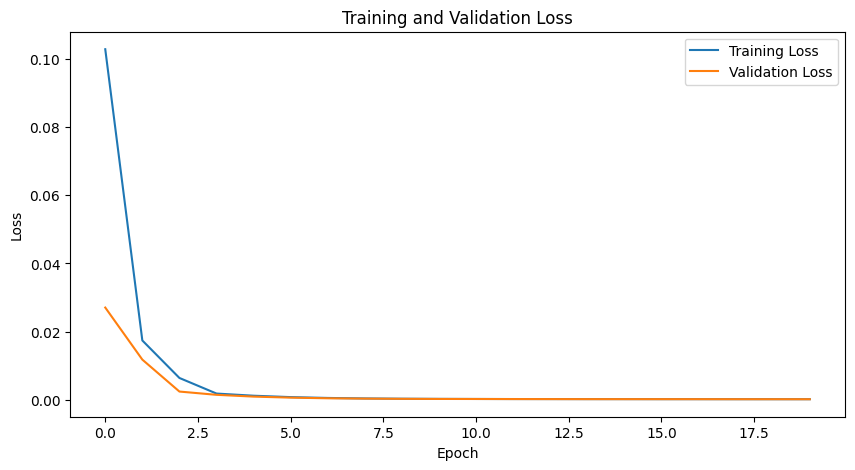

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

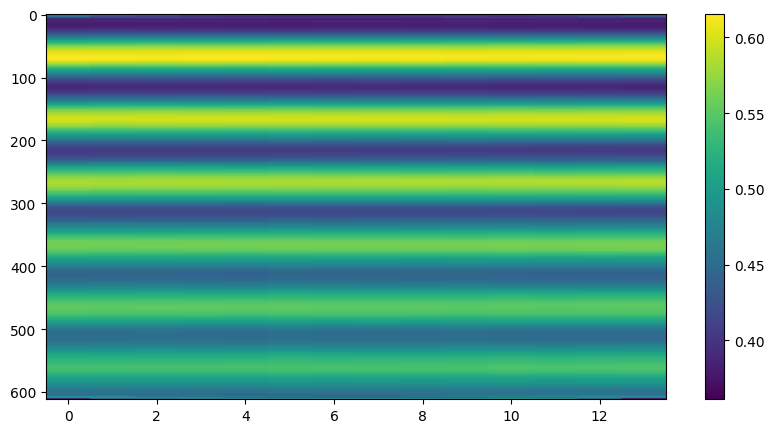

In [117]:
H_val_NN = H_NN_val.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

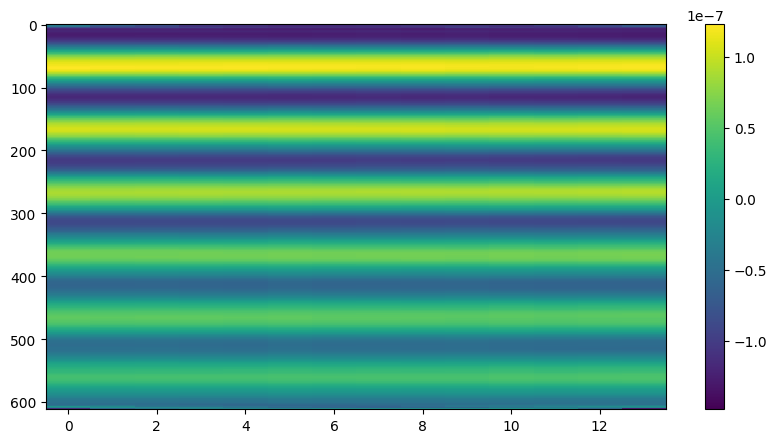

In [118]:
# De-normalized
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

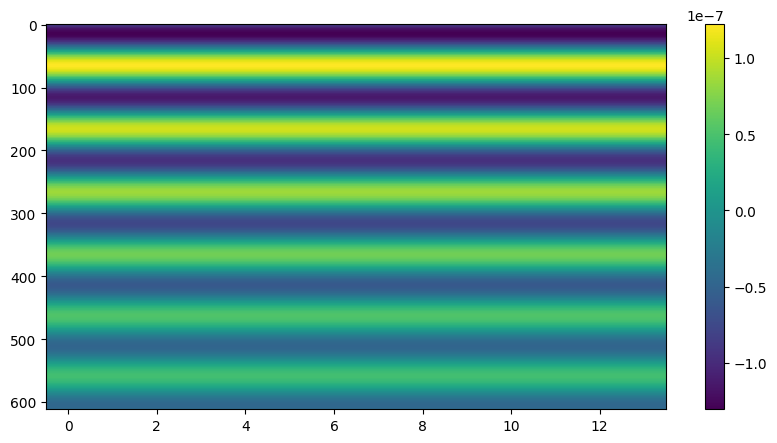

In [119]:
# True channel
H_val_true = valLabels.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

### Save LI+CNN Model

In [2]:
import loader
save_folder = os.path.join(config.FILE_PATH, 'model/static/CNN', rowss, str(snr)+'dB')

index_save = loader.find_incremental_filename(save_folder, 'CNN_', '_variable')
model_save_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LI_CNN_model.pth')
variable_save_path = os.path.join(save_folder, 'CNN_' +str(index_save)+'_variable.mat')

variables = {   
            'SNR': snr,
            'epoc': NUM_EPOCHS,
            'rows': rowss,
            'learning_rate': learning_rate,
            'H_val_true':H_val_true, # (nVal, 2, 612, 14)
            'H_val_LI_NN': H_val_NN, # (nVal, 2, 612, 14)
            'train_track_LI': train_loss,
            'val_track_LI': val_loss,
            'train_min_LI': trainData_min,
            'train_max_LI': trainData_max,
            'val_min': trainLabels_min,
            'val_max': trainLabels_max,
}
# variable to save 
# Save the models' state dictionaries 
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, model_save_path)


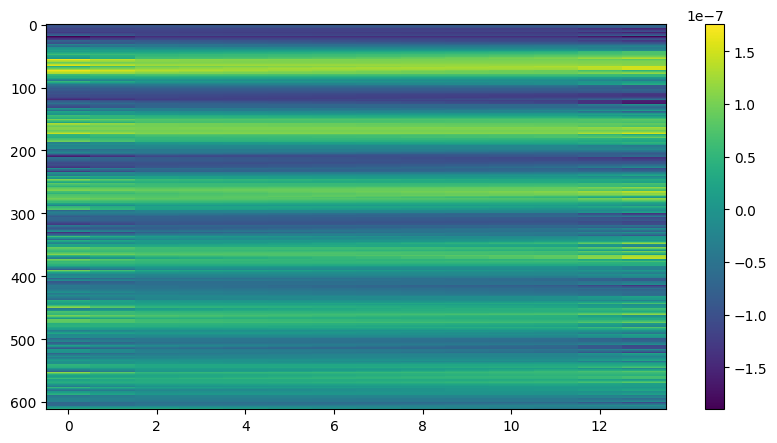

In [121]:
# Linear interpolated channel
H_val_linInterp = valData.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_linInterp[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [122]:
H_val_true.shape

torch.Size([367, 2, 612, 14])

In [123]:
# draw flow chart
# convert H to complex 
# check nmse formula in papers
# nmse vs SNR 
# try with GAN

### Calculate NMSE

In [124]:
# convert to complex matrices
H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:])
H_val_NN_denormd_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])
H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])

In [125]:
H_val_true_complex[1,1,1]

tensor(1.3010e-07+8.0067e-08j)

In [126]:
H_val_true_complex.shape

torch.Size([367, 612, 14])

In [127]:
# NMSE of Linear Interpolation
# Calculate the mean squared error
mse_LI = torch.mean(torch.abs(H_val_true_complex - H_val_linInterp_complex) ** 2)
# Calculate the variance of the reference tensor (complex_tensor1)
variance = torch.var(H_val_true_complex)
# Calculate the NMSE
nmse_LI = mse_LI / variance
print(f"NMSE: {nmse_LI.item()}")

NMSE: 0.08171968162059784


In [128]:
variables['NMSE_LI'] = nmse_LI

In [129]:
# NMSE of Linear Interpolation + NN
# Calculate the mean squared error
mse_LI_NN = torch.mean(torch.abs(H_val_true_complex - H_val_NN_denormd_complex) ** 2)
# Calculate the NMSE
nmse_LI_NN = mse_LI_NN / variance
print(f"NMSE: {nmse_LI_NN.item()}")

NMSE: 0.006854719948023558


In [130]:
variables['NMSE_LI_NN'] = nmse_LI_NN

# When Input of the NN is just H_equalized

In [131]:
# [samples, 2, 612, 14]
# Split into training and validation sets for H_NN training
trainData   = H_equal[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = H_true[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = H_equal[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = H_true[train_size:,:,:,:].to(device, dtype=torch.float)

In [132]:
# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData_normd   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels_normd = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData_normd     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels_normd   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)


In [133]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((trainData_normd[:,0,:,:], trainData_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((trainLabels_normd[:,0,:,:], trainLabels_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)


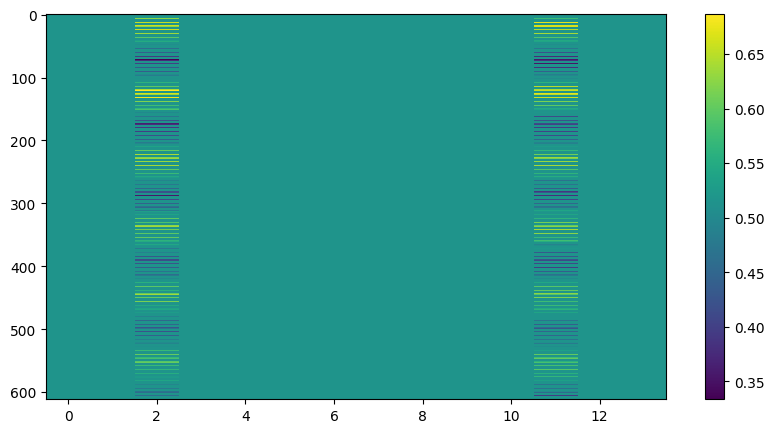

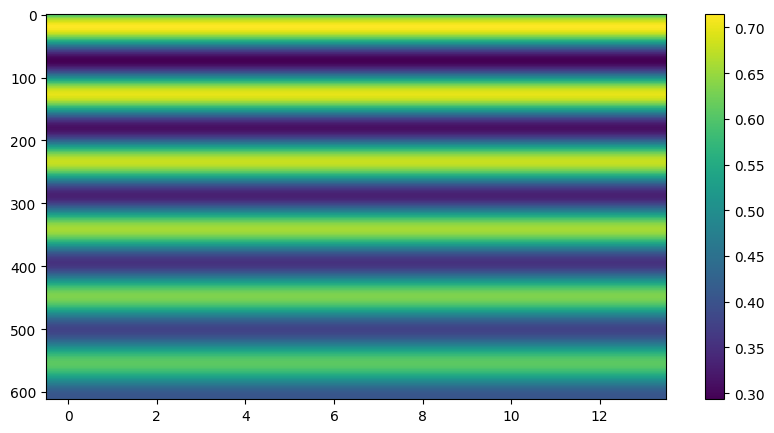

In [134]:
plot = 1
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

## Create a DataLoader for dataset

In [135]:
# Create a DataLoader for dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData_normd, valLabels_normd)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [136]:
model2 = CNN_Est().to(device)
learning_rate = 0.00001
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

## Training Loop

In [137]:
# Training loop
train_loss =[]
val_loss = []
H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    if (epoch == num_epochs-1):
        i = 0
    for inputs, targets in train_loader:
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = model2(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_val_loss += val_loss_real.item()
            
            val_outputs_imag = model2(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_val_loss += val_loss_imag.item()
            
            if (epoch == num_epochs-1):
                H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
            
    avg_val_loss = running_val_loss / (len(val_loader)*2)
    val_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")

Epoch 1/20, Loss: 0.1132936918681177 
 Val Loss: 0.03690915609089037
Epoch 2/20, Loss: 0.02768500922441793 
 Val Loss: 0.02395963901653886
Epoch 3/20, Loss: 0.02170539035190207 
 Val Loss: 0.01786759918710838
Epoch 4/20, Loss: 0.009283882354793604 
 Val Loss: 0.0015726894343970343
Epoch 5/20, Loss: 0.0010308147023655085 
 Val Loss: 0.0008341449914344897
Epoch 6/20, Loss: 0.0007578284609432254 
 Val Loss: 0.0006704116046118239
Epoch 7/20, Loss: 0.0006334343206617632 
 Val Loss: 0.0005772603362856898
Epoch 8/20, Loss: 0.0005476445217027504 
 Val Loss: 0.0005111566121437742
Epoch 9/20, Loss: 0.000483597850688966 
 Val Loss: 0.0004524324103840627
Epoch 10/20, Loss: 0.0004464908167089258 
 Val Loss: 0.00042764245639167103
Epoch 11/20, Loss: 0.0004214836876599293 
 Val Loss: 0.00043298601182565716
Epoch 12/20, Loss: 0.0004029773882242201 
 Val Loss: 0.00038647007871380384
Epoch 13/20, Loss: 0.0003869868372324466 
 Val Loss: 0.0003867659919099727
Epoch 14/20, Loss: 0.000377213299543655 
 Val 

## After training

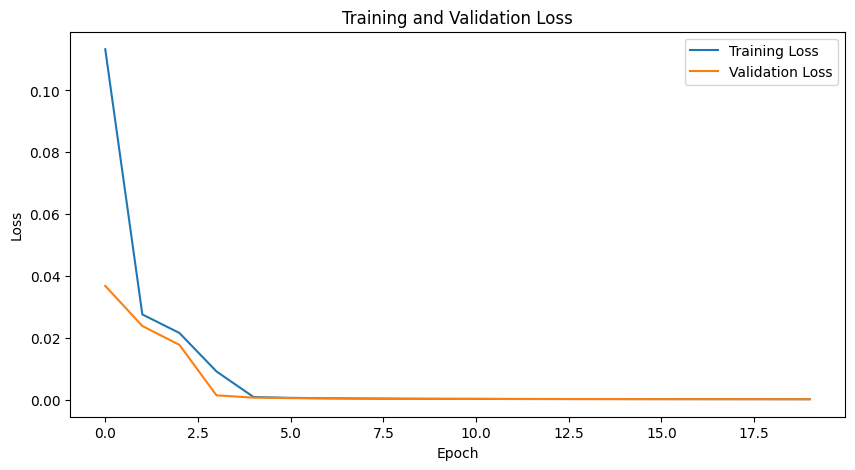

In [138]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [139]:
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()

### Save LS+CNN Model and Variables

In [140]:
model_save_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LS_CNN_model.pth')

variables['H_val_LS_NN']= H_val_NN # (nVal, 2, 612, 14)
variables['train_track_LS']= train_loss
variables['val_track_LS']= val_loss
variables['train_min_LS']= trainData_min
variables['train_max_LS']= trainData_max

# variable to save 
# Save the models' state dictionaries 
torch.save({'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, model_save_path)


In [141]:
H_val_LS_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])


In [142]:
# NMSE of LS + NN
# Calculate the mean squared error
mse_LS_NN = torch.mean(torch.abs(H_val_true_complex - H_val_LS_NN_complex) ** 2)
# Calculate the NMSE
nmse_LS_NN = mse_LS_NN / variance
print(f"NMSE: {nmse_LS_NN.item()}")

NMSE: 0.012295262888073921


In [143]:
variables['NMSE_LS_NN'] = nmse_LS_NN

### testing saving file

In [171]:
variables = {   
            'SNR': snr,
            'epoc': NUM_EPOCHS,
            # 'rows': rowss,
            'learning_rate': learning_rate,
            'H_val_true':H_val_true, # (nVal, 2, 612, 14)
            'H_val_LI_NN': H_val_NN, # (nVal, 2, 612, 14)
            'train_track_LI': train_loss,
            'val_track_LI': val_loss,
            'train_min_LI': trainData_min,
            'train_max_LI': trainData_max,
            'val_min': trainLabels_min,
            'val_max': trainLabels_max,
}

In [174]:
trainLabels_min

tensor(-5.3256e-07, device='cuda:1')

In [172]:
variable_save_path_pth = variable_save_path.replace(".mat", ".pth")
torch.save(variables, variable_save_path_pth)

In [176]:
pth_data_test = torch.load(variable_save_path_pth, map_location=torch.device('cpu'))
val_min = pth_data_test['train_min_LI']
print(val_min)

tensor(-8.1074e-07)


### end testing

# One-shot to ETS map-based channel

In [145]:
import os

project_directory = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
print("project_directory = ", project_directory)

mat_data_dir = os.path.join(project_directory, "CDL Customization/Data/test.mat")

# mat_data_dir = os.path.join(project_directory, "CDL Customization/Data"+ rowss, str(snr) + "dB.mat")
mat_data = scipy.io.loadmat(mat_data_dir)

project_directory =  /home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN


In [190]:
def unsqueeze_H(np_array):
    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array, dtype=torch.complex64)

    # Create a new tensor with shape (1, 2, 612, 14)
    # First, get the real and imaginary parts
    real_part = tensor.real.unsqueeze(0)  # Shape (1, 612, 14)
    imag_part = tensor.imag.unsqueeze(0)  # Shape (1, 612, 14)

    # Then, concatenate them along a new dimension
    combined = torch.cat((real_part, imag_part), dim=0)  # Shape (2, 612, 14)

    # Finally, add a batch dimension to get shape (1, 2, 612, 14)
    result_tensor = combined.unsqueeze(0)  # Shape (1, 2, 612, 14)
        
    return result_tensor


In [191]:
etsH_LS   = mat_data['H_equalized']
etsH_LI   = mat_data['H_linear']
etsH_true = mat_data['H_true']

### Normalized etsH_LS and etsH_LI based on the saved train_min, max 

In [ ]:
# saved variable file path 
saved_var_file = ''  # CNN_2_variable.pth
load_var = torch.load(saved_var_file)

# load saved train_min,max, val_min_max
train_min_LI = load_var['train_min_LI']
train_max_LI = load_var['train_max_LI']
train_min_LS = load_var['train_min_LS']
train_max_LS = load_var['train_max_LS']
val_min = load_var['val_min']
val_max = load_var['val_max']

In [192]:
etsH_LS_tensor = unsqueeze_H(etsH_LI) # (1,2,612,14)
etsH_LI_tensor = unsqueeze_H(etsH_LI) # (1,2,612,14)
etsH_true_tensor = unsqueeze_H(etsH_LI) # (1,2,612,14)

etsH_LS_normd = (etsH_LS_tensor - train_min_LS) * (train_max_LS - train_min_LS)
etsH_LI_normd = (etsH_LI_tensor - train_min_LI) * (train_max_LI - train_min_LI)
etsH_true_normd = (etsH_true_tensor - val_min) * (val_max - val_min)   
                                            # for the estimated channel, we will need to de-normalized

### Visualize Data and Label

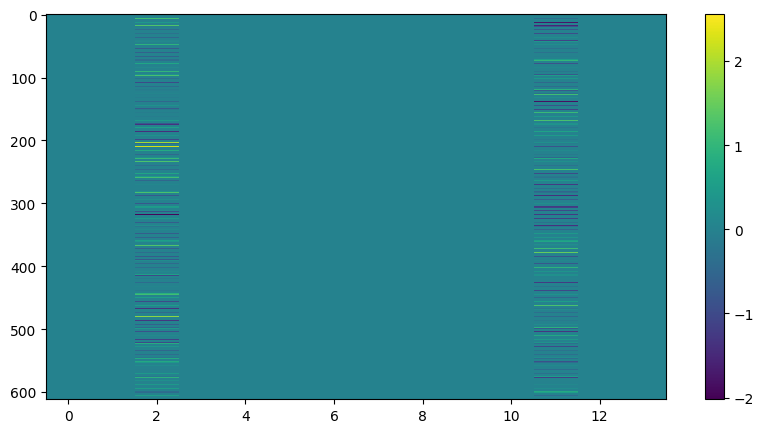

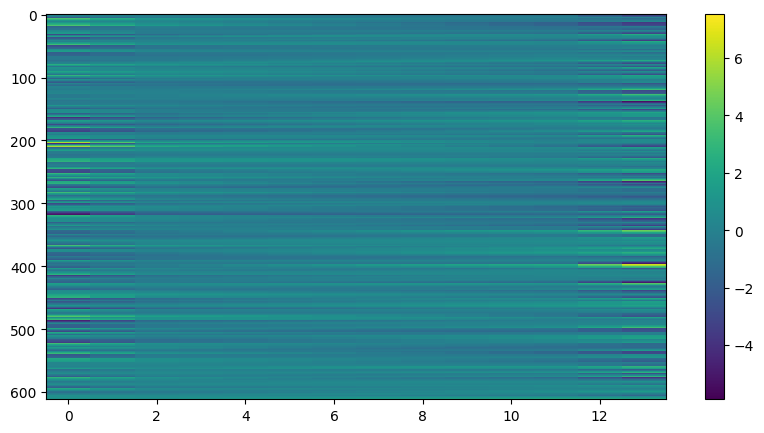

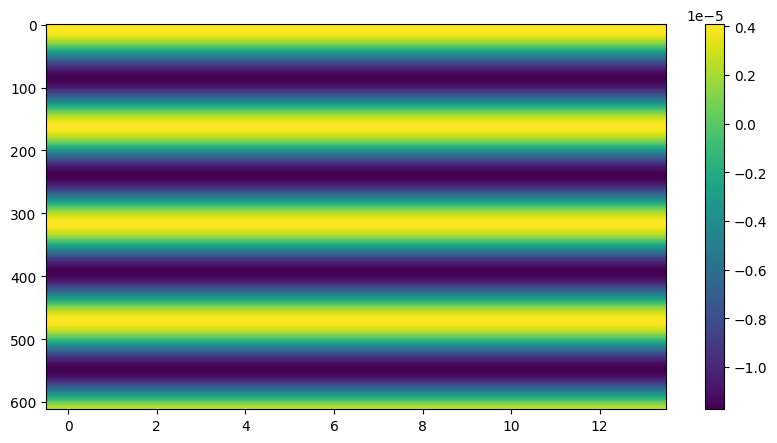

In [147]:
plt.figure(figsize=(10, 5))
plt.imshow(np.real(etsH_LS[:,:]),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS Map-based channel normalized by training settings')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(np.real(etsH_LI[:,:]),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI Map-based channel normalized by training settings')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(np.real(etsH_true[:,:]),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('True channel normalized by validating settings')
plt.colorbar()
plt.show()

## (LS+LI) model 

In [ ]:
etsH_LI_normd_real = etsH_LI_normd[:,0,:,:].unsqueeze(1)
etsH_LI_normd_imag = etsH_LI_normd[:,1,:,:].unsqueeze(1)

etsH_LS_normd_real = etsH_LS_normd[:,0,:,:].unsqueeze(1)
etsH_LS_normd_imag = etsH_LS_normd[:,1,:,:].unsqueeze(1)

etsH_true_normd_real = etsH_true_normd[:,0,:,:].unsqueeze(1)
etsH_true_normd_imag = etsH_true_normd[:,1,:,:].unsqueeze(1)

In [ ]:
ets_model = CNN_Est()
LI_model_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LI_CNN_model.pth')
saved_model = torch.load(LI_model_path)

ets_model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])

In [196]:
model_cpu = model.to('cpu')

In [197]:
ets_estimatedLI_real = model_cpu(etsH_LI_normd_real)
# similar with imag part

In [207]:
ets_estimatedLI_real.device
tensor_for_plot = ets_estimatedLI_real[0, 0, :, :].detach().cpu().numpy()

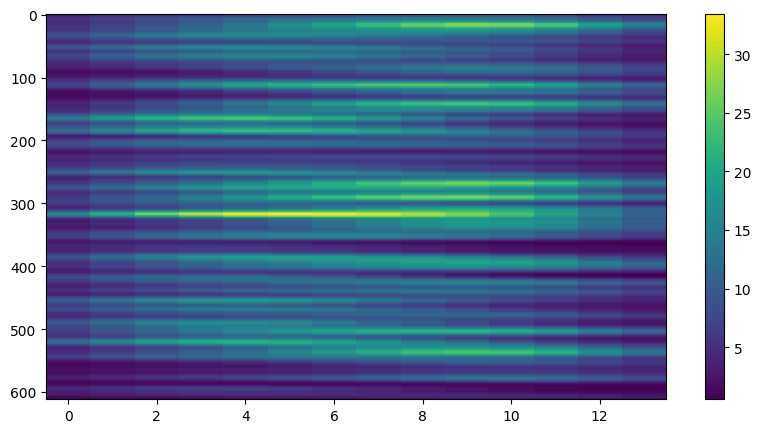

In [209]:
plt.figure(figsize=(10, 5))
plt.imshow(tensor_for_plot[:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
# de-normalized the output
# load saved variable
# De-normalized
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
# calculate MSE

# calculate NMSE 

## (LS-only)-preprocessed model 